In [1]:
import numpy as np 
import pandas as pd
from datetime import datetime, date 
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA


# read in cleaned data, confirmed COVID cases and death

alldata = pd.read_csv('CleanedData.csv', header = 0)

#confirmed.index = pd.to_datetime(confirmed.index)
alldata['Date'] = pd.to_datetime(alldata['Date'])


alldata.head()

,confirmed,death,state,Date
0,0,0,Alabama,2020-01-22
1,0,0,Alabama,2020-01-23
2,0,0,Alabama,2020-01-24
3,0,0,Alabama,2020-01-25
4,0,0,Alabama,2020-01-26


# see Connecticut newly added cases, confirmed and death

c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


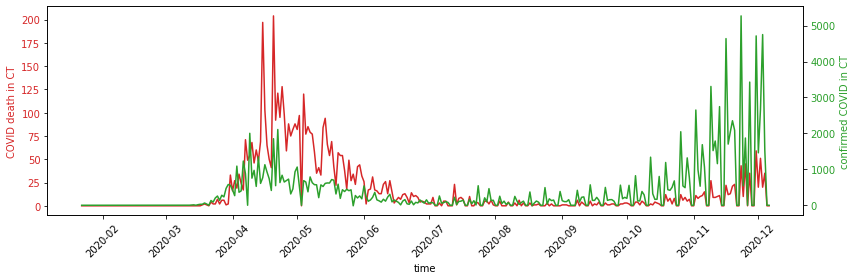

In [26]:
ct = alldata[alldata['state'] == 'Connecticut']

newconfirmed= np.zeros([len(ct)])
newdeath = np.zeros([len(ct)])

for i in range(len(ct)-1):
    newconfirmed[i+1] = ct['confirmed'].iloc[i+1] - ct['confirmed'].iloc[i] 
    newdeath[i+1] = ct['death'].iloc[i+1] - ct['death'].iloc[i] 

ct['added confirmed'] = newconfirmed
ct['added death'] = newdeath


# double plot on newly added cases and death
fig, ax1 = plt.subplots(figsize = (12,4))

ax1.set_xlabel('time (s)')
ax1.set_ylabel('COVID death in CT', color='tab:red')
ax1.plot(ct['Date'], ct['added death'], label = 'death', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
plt.xlabel('time'), plt.ylabel('COVID death in CT'), plt.xticks(rotation = 45)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('confirmed COVID in CT', color='tab:green')  # we already handled the x-label with ax1
ax2.plot(ct['Date'], ct['added confirmed'], color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()


## use ARMA to predict confirmed COVID cases

In [16]:
# use the first 280 data points to train, last 40 data points to validate

train = ct.iloc[0:280,:]
train.set_index('Date', drop = True, inplace = True)
test = ct.iloc[281:320,:]
test.set_index('Date', drop = True, inplace = True)


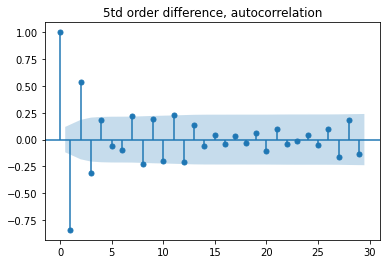

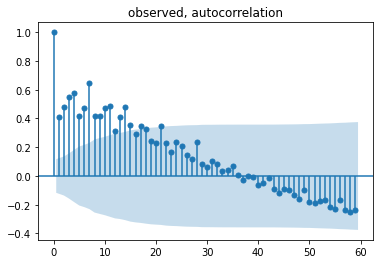

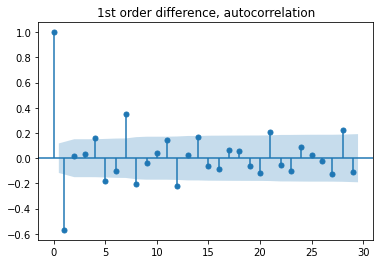

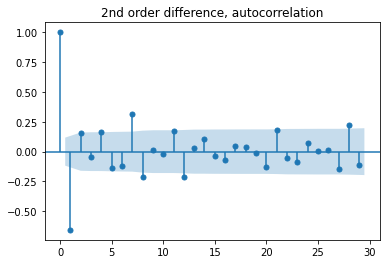

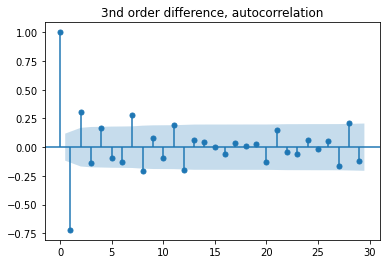

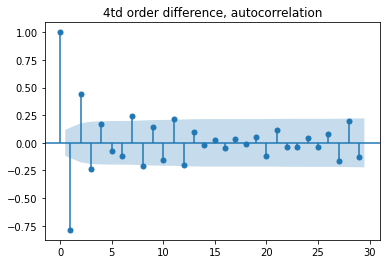

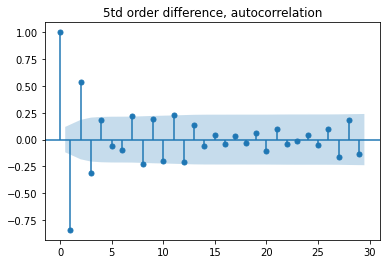

In [52]:
# plot auto & partial correlation plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train['added confirmed'].dropna(), lags=np.arange(60), alpha = 0.05, title = 'observed, autocorrelation' )
plot_acf(train['added confirmed'].diff().dropna(), lags=np.arange(30), alpha = 0.05, title = '1st order difference, autocorrelation' )
plot_acf(train['added confirmed'].diff().diff().dropna(), lags=np.arange(30), alpha = 0.05, title = '2nd order difference, autocorrelation' )
plot_acf(train['added confirmed'].diff().diff().diff().dropna(), lags=np.arange(30), alpha = 0.05, title = '3nd order difference, autocorrelation' )
plot_acf(train['added confirmed'].diff().diff().diff().diff().dropna(), lags=np.arange(30), alpha = 0.05, title = '4td order difference, autocorrelation' )
plot_acf(train['added confirmed'].diff().diff().diff().diff().diff().dropna(), lags=np.arange(30), alpha = 0.05, title = '5td order difference, autocorrelation' )


In [69]:
from statsmodels.tsa.stattools import adfuller


def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

adf_test(train['added confirmed'])

1. ADF :  -2.0518170624334755
2. P-Value :  0.2643250314684192
3. Num Of Lags :  16
4. Num Of Observations Used For ADF Regression: 263
5. Critical Values :
	 1% :  -3.4554613060274972
	 5% :  -2.8725931472675046
	 10% :  -2.5726600403359887


c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\users\yuezhe\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:        added confirmed   No. Observations:                  280
Model:                ARIMA(14, 0, 3)   Log Likelihood               -1908.397
Date:                Wed, 30 Dec 2020   AIC                           3854.794
Time:                        12:31:52   BIC                           3923.855
Sample:                    01-22-2020   HQIC                          3882.495
                         - 10-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        245.1368    262.981      0.932      0.351    -270.296     760.570
ar.L1          0.4539      0.381      1.191      0.234      -0.293       1.201
ar.L2         -0.5097      0.211     -2.421      0.0

<AxesSubplot:ylabel='Frequency'>

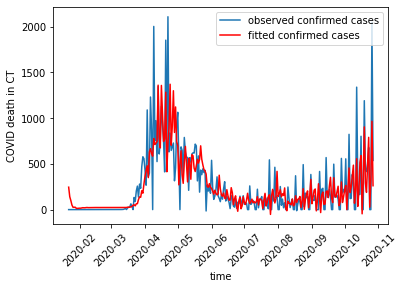

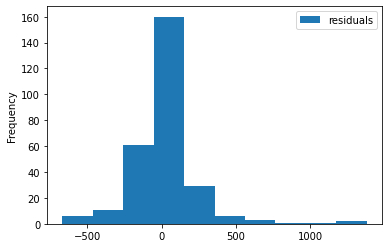

In [112]:
# use training data to fit for an ARMA data

from statsmodels.tsa.arima.model import ARIMA

arma_mod = ARIMA(train['added confirmed'], order=(14,0,3))
res = arma_mod.fit()
print(res.summary())

# plot fitted data against observed data
plt.plot(train['added confirmed'], label = 'observed confirmed cases')
plt.plot(res.fittedvalues, color='red', label = 'fitted confirmed cases')
plt.xlabel('time'), plt.ylabel('COVID death in CT'), plt.xticks(rotation = 45)
plt.legend()
# plot residual 
residuals = pd.DataFrame(res.resid, columns=['residuals'])
residuals.plot(kind='hist')

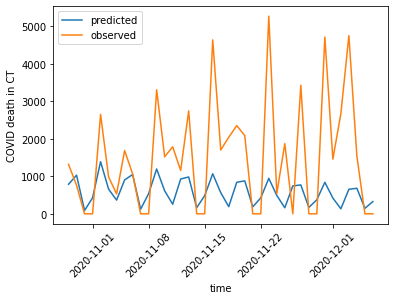

In [113]:
## check prediction results

plt.plot(res.predict(start=test.index[0], end=test.index[-1]), label = 'predicted')
plt.plot(test['added confirmed'], label = 'observed')
plt.xlabel('time'), plt.ylabel('COVID death in CT'), plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [119]:
mean_squared_error(res.predict(start=test.index[0], end=test.index[-1]), test['added confirmed'],squared=False)/ np.mean( test['added confirmed'])

1.0935467098144687